# MLE en estimación de compradores en supermercado.
### André Robles Bueckmann 

Dato un conjunto de datos de ganancias y ratings por transacción de comunidades y locales en una región (en donde las ventas ya descuentan el precio de producción de un producto e impuestos), queremos evaluar la viabilidad de colocar un nuevo supermercado que genere 1.5M de pesos de ganancia neta. Para esto se realiza tanto una aproximación de distribución con la función máxima de similitud (MLE) así como observaciones de los ratings dados por los consumidores por cada experiencia de compra (venta del supermercado).

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm
from scipy.optimize import fsolve
print("Done")

Done


Para este propósito hacemos uso de la función de distribución de probabilidad "Beta". Esta nos proporciona la flexibilidad suficiente para poder ajustar correctamente los parámetros mu y sigma a los datos dados. Iniciamos normalizando los datos de las ventas [0, 1], pues es lo que naturalmente nos pide la distribución, para después calcular el valor de los coeficientes Alpha y Beta.

In [50]:
df = pd.read_csv("SuperMarketData.csv")
print(df.head())
sales = np.array(df["Sales"])*19.88 # convertimos a pesos
# Normalizamos
max_sales = max(sales)
min_sales = min(sales)
sales_norm = (1/(max_sales - min_sales)) * (sales - min_sales)
a,b,_,_=beta.fit(sales)
print(a,b)

      Sales  Rating
0  548.9715     9.1
1   80.2200     9.6
2  340.5255     7.4
3  489.0480     8.4
4  634.3785     5.3
1.0343378458769883 2.912435546737946


Una vez obtenidos los coeficientes, comenzamos por desnormalizar los parámetros de nuestra distribución para poder trabajar con las estimaciones.

In [51]:
mu_norm = a / (a + b)
var_norm = (a * b) / ((a + b) ** 2 * (a+b+1))
desv_norm = np.sqrt(var_norm)
mu = mu_norm * (max_sales - min_sales) + min_sales
var = (max_sales - min_sales) ** 2 * var_norm
sigma = np.sqrt(var)
print(f"mu: {mu}, sigma: {sigma})")

mu: 5588.846237107233, sigma: 4056.395134259388)


Con el propósito de hacer un pronóstico más fiable, vamos a considerar los gastos totales siguientes: Nóminas, luz, agua, así como incorporar el beneficio que queremos forzar generar (1.5M de pesos). La variable *ingreso*.

In [52]:
#------Salarios------
# Factor para trabajos de remuneración mínima
fact = 1.15

sal_cajeros = 258.25
num_cajeros = 30
dias_t = 24
tot_sal_caj = sal_cajeros * num_cajeros*dias_t*fact

sal_conserjes = 5000
num_conserjes = 20
tot_sal_conserjes = sal_conserjes* num_conserjes*fact

gerente = 100000
sub_gerentes = 45000
num_subgerentes = 4
tot_sal_sub = sub_gerentes*num_subgerentes

sal_almacenista = 262.13
num_almacenista = 40
tot_sal_alm = sal_almacenista*num_almacenista*dias_t*fact

g_pasillo = 264.65
num_pasillos = 40
tot_pasillo = g_pasillo*num_pasillos*fact

nomina_tot = tot_sal_caj + tot_sal_conserjes + tot_sal_sub + gerente + tot_sal_sub + tot_sal_alm + tot_pasillo
print(f'Nomina total: {nomina_tot}')

# Para una sucursal de 2000 m^2, (120kW/hr)m^2 abierta 12 hrs donde se cobra $2.3 por kW/hr
gasto_luz = 120*2000*12*2.3
print(gasto_luz)

# Para una sucursal con 94 empleados, estimando 3 usos de baño por día. Se asumen 100 usos de clientes al día. Se calcula gasto mensual. $265.2 por m^3, que equivalen a 1000 litros.
gasto_agua = (16 * (94 + 100) * 30 * 265.2) / 1000
print(gasto_agua)

gastos_tot = gasto_luz+gasto_agua+nomina_tot
ingreso = gastos_tot + 1500000

Nomina total: 1090396.42
6623999.999999999
24695.424


Una vez obtenido nuestro parámetros optimizados de la distribución "Beta" así como nuestros ingresos totales, podemos calcular la cantidad de ventas que necesitamos para llegar a nuestros ingresos objetivos dándo un valor de confianza "z", en cuál en este caso se establece como 1%. Es decir, queremos que solo en el 1% de las ocasiones el valor de nuestras ventas sea menor al umbral (ingreso).

La fórmula utilizada para posteriormente resolver con *fsolve* viene de la normalización de un valor con respecto a la distribución normal "(Z = Sn - mu * N) / (sigma * sqrt(n))", la cual es igualada a 0.

In [53]:
def dist_normal_est(N):
    Z = norm.ppf(0.01)
    return (mu * N + Z * sigma * np.sqrt(N))**2 - ingreso**2

valor_entrenado = ingreso/mu
print("Valor entrenado de N:", valor_entrenado)
N = fsolve(dist_normal_est, valor_entrenado)
print("Cantidad estimada de ventas:", N[0])

poblacion = N/4
porcentaje_poblacion = poblacion/40000
print(f"Porcentaje de la población que debe visitar el supermercado semanalmente: {porcentaje_poblacion[0]:.4f}% con un consumo aproximado de {mu:.2f} pesos.")

Valor entrenado de N: 1653.1304408872268
Cantidad estimada de ventas: 1723.2216119882273
Porcentaje de la población que debe visitar el supermercado semanalmente: 0.0108% con un consumo aproximado de 5588.85 pesos.


Ahora, observemos la distribución ofrecida por los ratings de cada venta de nuestros datos. Esto con el propósito de encontrar una distribución la cuál parezca modelarlo, así como calcular la probabilidad de que la media de nuestros clientes den un rating de 8.5, el cuál se asigna de manera arbitraria como un puntaje "favorable".

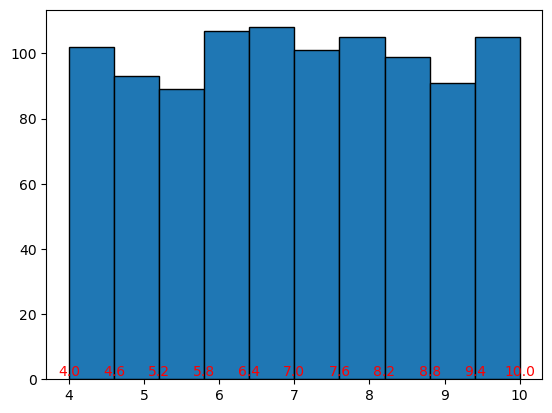

In [54]:
ratings = np.array(df['Rating'])
n, bins, patches = plt.hist(ratings, edgecolor="black")
for num in bins:
  plt.text(num, 1, round(num, 2), ha='center', color='red')

De la distribución bruta graficada, parece difícil llegar a una conclusión irrefutable acerca de la distribución más adecuada. Sin embargo, podemos elegir nuevamente la distribución de probabilidad "Beta" dado que existe un intervalo finito de valores [0, 10]. Así, graficamos una vez más pensado en una normalización de la distribución "Beta".

0.8923738272226862 0.9934875526087485
mu: 6.839149802099823, sigma: 1.7634306205368828)


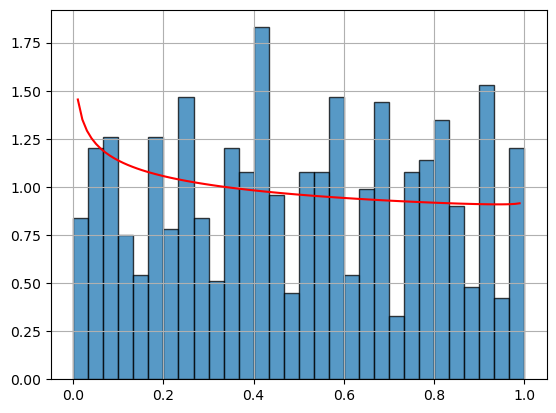

In [55]:
max_ratings = max(ratings)
min_ratings = min(ratings)
ratings_norm = (1/(max_ratings - min_ratings)) * (ratings - min_ratings)
a,b,_,_=beta.fit(ratings)
print(a,b)

mu_norm = a / (a + b)
var_norm = (a * b) / ((a + b) ** 2 * (a+b+1))
desv_norm = np.sqrt(var_norm)
mu = mu_norm * (max_ratings - min_ratings) + min_ratings
var = (max_ratings - min_ratings) ** 2 * var_norm
sigma = np.sqrt(var)
print(f"mu: {mu}, sigma: {sigma})")

n, bins, patches = plt.hist(ratings_norm, bins=30, density=True, alpha=0.75, edgecolor="black", label='Histograma de Ratings Normalizados')
x = np.linspace(0, 1, 100)
y = beta.pdf(x, a, b)
plt.plot(x, y, 'r-', label='Distribución Beta ajustada')
plt.grid(True)
plt.show()

Podemos con esto calcular la probabilidad de que el rating de nuestro supermercado sea de 8.5, bajo la suposición de tener un comportamiento parecido. Tomando en cuenta que cada rating es independiente entre sí, una cantidad grande de estos a pesar de haber sido contruida con una función "Beta", puede pensarse que tiende a una distribución normal.

In [56]:
prob = 1 - norm.cdf(8.5, mu, sigma)
print(f"La probabilidad de que la media de los ratings sea al menos 8.5 es aproximadamente {prob}") 

La probabilidad de que la media de los ratings sea al menos 8.5 es aproximadamente 0.17314008309421802


Considerando que la media resultante de la distribución es aproximadamente 17.31%, bastante lejos de una probabilidad que pueda siquiera acercarse a ser aleatoria (50%), los resultados de los "ratings" de ventas realizadas en la región no son favorables. Por tanto, sería hipotéticamente prudente informar al departamento de atención al cliente del supermercado que una buena atención y servicio puede no solo ser fundamental para la permanencia del supermercado sino para obtener un consumidor fiel por ofrecer este diferenciador.

## Referencias
Sueldos 2024. Glassdoor. https://www.glassdoor.com.mx/Sueldos

Salarios mínimos 2024. CONASAMI. https://www.gob.mx/cms/uploads/attachment/file/873886/Tabla_de_Salarios_M_nimos_2024.pdf

Costo real del agua. Regulación y tarifas: IMCO. https://imco.org.mx/wp-content/uploads/2023/08/Investigacion_Costo-real-del-agua-en-Mexico_31082023-1.pdf